In [1]:
from main import read_in_blicks, BOUNDARY, eval_auc
import scorers
import datasets
import informants
import learners
from util import entropy, kl_bern

In [2]:
import pandas as pd

In [3]:
feature_type = 'atr_harmony'
SEED=1

## Load dataset, scorers, and oracle


In [4]:
lexicon_path = f'data/hw/{feature_type}_lexicon.txt'
phoneme_feature_path = f'data/hw/{feature_type}_features.txt'
ngram_feature_path = f'data/hw/{feature_type}_feature_weights.txt'

print(f'Loading lexicon from:\t{lexicon_path}')
dataset = datasets.load_lexicon(lexicon_path, min_length=2, max_length=5)

# You'll probably want to change this line to create your own scorer
mf_scorer = scorers.MeanFieldScorer(dataset, 
                                    feature_type=feature_type, 
                                    phoneme_feature_file=phoneme_feature_path,
                                   )
hw_scorer = scorers.HWScorer(dataset, 
                                    feature_type=feature_type, 
                                    phoneme_feature_file=phoneme_feature_path,
                            )

# Load oracle
informant = informants.HWInformant(dataset, hw_scorer)

Loading lexicon from:	data/hw/atr_harmony_lexicon.txt
Loading lexicon with min_length=2, max_length=5...
Reading phoneme features from: data/hw/atr_harmony_features.txt
# features:  512
feature type:  atr_harmony
Reading phoneme features from: data/hw/atr_harmony_features.txt
Loading ngram features from: data/hw/atr_harmony_feature_weights.txt


## Set random seeds

In [5]:
import random
import numpy as np

random.seed(SEED)
np.random.seed(SEED)
dataset.random.seed(SEED)

In [6]:
linear_train_dataset = dataset.data

## Load eval dataset

In [7]:
# Read in eval dataset

def load_eval_dataset():

    # Change this path if you want to specify a different eval dataset
    # eval_dataset_path = f'{feature_type}_test_set.txt'

    # Hacky, but the atr_harmony test set is stored at test_set.csv; the eval dataset names need to be standardized
    eval_dataset_path = 'test_set.csv'
    print(f'Reading eval items from:\t{eval_dataset_path}')
    items = read_in_blicks(eval_dataset_path)


    # Get phonemes
    phonemes = [[BOUNDARY] + item + [BOUNDARY] for item in items]
    # Encode items
    encoded_items = [dataset.vocab.encode(phon) for phon in phonemes]
    # Get labels with HW oracle
    labels = [informant.judge(encod) for encod in encoded_items]
    # Featurize items
    featurized_items = [mf_scorer._featurize(encod).nonzero()[0] for encod in encoded_items]
    # Get num features

    # Get dataframe of results
    eval_dataset = pd.DataFrame({
        'item': items,
        'label': labels,
        'encoded': encoded_items,
        'featurized': featurized_items,
    })

    return eval_dataset

In [8]:
eval_dataset = load_eval_dataset()
display(eval_dataset)

Reading eval items from:	test_set.csv


,item,label,encoded,featurized
0,"[ta, qI]",True,"(0, 20, 2, 0)","[70, 94, 110, 134, 158, 174, 392, 395, 397, 40..."
1,"[qe, qe]",True,"(0, 7, 7, 0)","[78, 94, 102, 206, 222, 230, 270, 286, 294, 39..."
2,"[qE, pi, qE, qI]",False,"(0, 19, 8, 19, 2, 0)","[8, 11, 13, 24, 27, 29, 40, 43, 45, 65, 67, 69..."
3,"[kI, ta]",True,"(0, 14, 20, 0)","[14, 22, 206, 214, 334, 342, 385, 386, 409, 41..."
4,"[ke, qI]",False,"(0, 18, 2, 0)","[70, 94, 110, 198, 222, 238, 262, 286, 302, 39..."
...,...,...,...,...
1005,"[kI, qe, ta, qi, qa, ke]",False,"(0, 14, 7, 20, 15, 11, 18, 0)","[9, 10, 11, 12, 17, 19, 20, 25, 26, 33, 34, 65..."
1006,"[qa, ta, ta, pE]",True,"(0, 11, 20, 20, 10, 0)","[73, 74, 75, 77, 78, 81, 82, 83, 85, 94, 110, ..."
1007,"[pe, tE, pa]",False,"(0, 17, 6, 9, 0)","[73, 74, 78, 86, 89, 90, 105, 106, 201, 202, 2..."
1008,"[ka, ti, ke]",True,"(0, 5, 12, 18, 0)","[14, 30, 38, 65, 67, 68, 89, 91, 92, 97, 99, 1..."


## Initialize learner

In [15]:
# You may also have to create a slightly modified learner class to wrap around your linear model scorer
learner = learners.VBLearner(dataset, strategy='unif', 
                             linear_train_dataset=linear_train_dataset,
                            index_of_next_item=0,
                            seed=SEED)
learner.initialize(n_hyps=1, 
                   log_log_alpha_ratio=0.5, 
                   prior_prob=0.03125,
                   feature_type=feature_type, 
                   tolerance=0.001/512,
                   warm_start=False,
                   max_updates_observe=None,
                   max_updates_propose=None,
                  )

Reading phoneme features from: data/hw/atr_harmony_features.txt
# features:  512


## Main loop

In [17]:
def get_auc(learner, eval_dataset):
    # Learner.cost() is used to get predictions for the test set
    costs = [learner.cost(encod) for encod in eval_dataset['encoded'].values]
    auc = eval_auc(costs, eval_dataset['label'].values)
    return auc

In [11]:
from tqdm import tqdm

num_samples = 10

num_candidates = 100

aucs=[]

for i in tqdm(range(num_samples)):
    
    # Propose candidate with strategy (defaults to 'unif' above)
    cand = learner.propose(num_candidates, 
                           forbidden_data=[], 
                           length_norm=True, 
                           train_expect_type=None,
                           informant=informant,
                          )
    # Get judgment for candidate
    judgment = informant.judge(cand)
    
    orig_probs = learner.hypotheses[0].probs
    entropy_before = entropy(orig_probs)
    
    # Learn from the candidate (calls update())
    learner.observe(cand, judgment)
    
    # Compute metrics evaluating learning
    new_probs = learner.hypotheses[0].probs
    entropy_after = entropy(new_probs)
    info_gain = entropy_before - entropy_after
    kl = kl_bern(new_probs, orig_probs).sum()
    str_candidate = dataset.vocab.decode(cand)
    
    auc = get_auc(learner, eval_dataset)
    aucs.append(auc)
    
    # Print
    print("")
    print(f"candidate: {str_candidate}")
    print(f"kl between prior and posterior: {kl}")
    print(f"info gain: {round(info_gain, 3)}")
    print(f"auc: {auc}")
    
    print("================================")

  0%|                                                                                         | 0/10 [00:00<?, ?it/s]

setting num_edits = 0 because there are no train observations
num edit candidates: 0
# candidates: 100
sorted candidates (candidate, score):
0 ('$', 'ti', 'te', 'pa', '$')
0 ('$', 'ti', 'tE', 'ki', '$')
0 ('$', 'pe', 'qI', '$')
0 ('$', 'pi', 'kI', '$')
0 ('$', 'qe', 'qE', '$')

candidate: ('$', 'ti', 'te', 'pa', '$')
kl between prior and posterior: 1.0447109964051946
info gain: 4.585
auc: 0.7454572950381799
setting num_edits = 0 because there are no train observations
num edit candidates: 0
# candidates: 100
sorted candidates (candidate, score):
0 ('$', 'tE', 'qe', 'qE', 'qE', '$')
0 ('$', 'pi', 'pe', 'pi', 'ti', '$')
0 ('$', 'qi', 'pa', 'pa', '$')
0 ('$', 'pe', 'tI', '$')
0 ('$', 'pI', 'pi', '$')


 50%|████████████████████████████████████████▌                                        | 5/10 [00:05<00:04,  1.21it/s]


candidate: ('$', 'tE', 'qe', 'qE', 'qE', '$')
kl between prior and posterior: 8.379477283787523
info gain: -16.176
auc: 0.7697341545423122
setting num_edits = 0 because there are no train observations
num edit candidates: 0
# candidates: 100
sorted candidates (candidate, score):
0 ('$', 'pI', 'qE', 'qI', '$')
0 ('$', 'qi', 'pE', '$')
0 ('$', 'ta', 'pa', '$')
0 ('$', 'te', 'qi', 'ke', '$')
0 ('$', 'qa', 'qE', '$')

candidate: ('$', 'pI', 'qE', 'qI', '$')
kl between prior and posterior: 0.006263661364541822
info gain: 0.387
auc: 0.7692588693712095
setting num_edits = 0 because there are no train observations
num edit candidates: 0
# candidates: 100
sorted candidates (candidate, score):
0 ('$', 'kI', 'qa', 'ke', 'qI', '$')
0 ('$', 'ki', 'ke', 'qI', '$')
0 ('$', 'tI', 'pI', 'ta', 'ta', '$')
0 ('$', 'pi', 'kE', '$')
0 ('$', 'te', 'qi', '$')

candidate: ('$', 'kI', 'qa', 'ke', 'qI', '$')
kl between prior and posterior: 0.0555441275568859
info gain: -0.081
auc: 0.7645649373094932
setting num

 70%|████████████████████████████████████████████████████████▋                        | 7/10 [00:05<00:01,  1.89it/s]


candidate: ('$', 'pI', 'te', '$')
kl between prior and posterior: 3.899099440619621
info gain: 5.355
auc: 0.8515853313641077
setting num_edits = 0 because there are no train observations
num edit candidates: 0
# candidates: 100
sorted candidates (candidate, score):
0 ('$', 'pa', 'pa', 'ti', 'ti', '$')
0 ('$', 'te', 'pa', 'ka', '$')
0 ('$', 'ke', 'tE', 'ki', 'ta', '$')
0 ('$', 'pI', 'pE', 'pa', 'tI', '$')
0 ('$', 'kE', 'tE', 'qE', 'qi', '$')

candidate: ('$', 'pa', 'pa', 'ti', 'ti', '$')
kl between prior and posterior: 0.18410010439173413
info gain: 2.064
auc: 0.8490360745372844
setting num_edits = 0 because there are no train observations
num edit candidates: 0
# candidates: 100
sorted candidates (candidate, score):
0 ('$', 'ki', 'qa', 'te', 'pa', '$')
0 ('$', 'qa', 'te', 'pe', 'tI', '$')
0 ('$', 'pI', 'pE', 'tE', 'ke', '$')
0 ('$', 'pi', 'qi', 'tI', '$')
0 ('$', 'pI', 'pI', 'pE', 'qa', '$')


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


candidate: ('$', 'ki', 'qa', 'te', 'pa', '$')
kl between prior and posterior: 7.765571306074014
info gain: 15.081
auc: 0.8191127486409201
setting num_edits = 0 because there are no train observations
num edit candidates: 0
# candidates: 100
sorted candidates (candidate, score):
0 ('$', 'pe', 'qa', '$')
0 ('$', 'qi', 'ki', 'kE', '$')
0 ('$', 'ti', 'ti', '$')
0 ('$', 'ti', 'kE', 'qi', '$')
0 ('$', 'qE', 'qE', 'tI', 'pI', '$')

candidate: ('$', 'pe', 'qa', '$')
kl between prior and posterior: 1.614952529959699e-06
info gain: 0.002
auc: 0.8191206045941615
setting num_edits = 0 because there are no train observations
num edit candidates: 0
# candidates: 99
sorted candidates (candidate, score):
0 ('$', 'qe', 'qi', '$')
0 ('$', 'kI', 'ki', '$')
0 ('$', 'qe', 'qi', 'qE', '$')
0 ('$', 'te', 'ki', 'qI', 'kI', '$')
0 ('$', 'ta', 'qa', 'pa', 'ki', '$')

candidate: ('$', 'qe', 'qi', '$')
kl between prior and posterior: 0.5114086878375312
info gain: 1.496
auc: 0.829565094428558


Text(0, 0.5, 'auc')

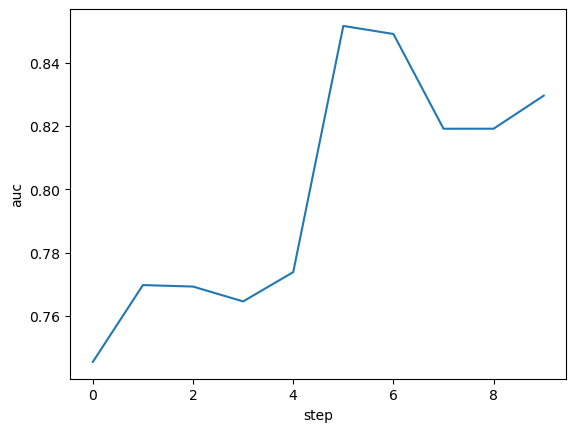

In [12]:
# Plot auc
import matplotlib.pyplot as plt
plt.plot(range(num_samples), aucs)
plt.xlabel('step')
plt.ylabel('auc')